In [12]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

# def sal(MH,aM,CFE,NFE,FEH): #Salaris correction
#     CM = CFE + FEH - MH
#     NM = NFE + FEH - MH
#     newalpha = np.log10(10**aM+10**CM+10**NM)
#     return MH + np.log(0.638*(10**(newalpha))+0.362)

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
clnpdfout = pdfout[clnr]

Labels for PARSEC isochrones

0 = PMS, pre main sequence

1 = MS, main sequence

2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars

3 = RGB, red giant branch, or the quick stage of red giant for intermediate+massive stars

4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars

5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars

6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars

7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for massive stars

8 = TPAGB, the thermally pulsing asymptotic giant branch

9 = post-AGB (in preparation!)

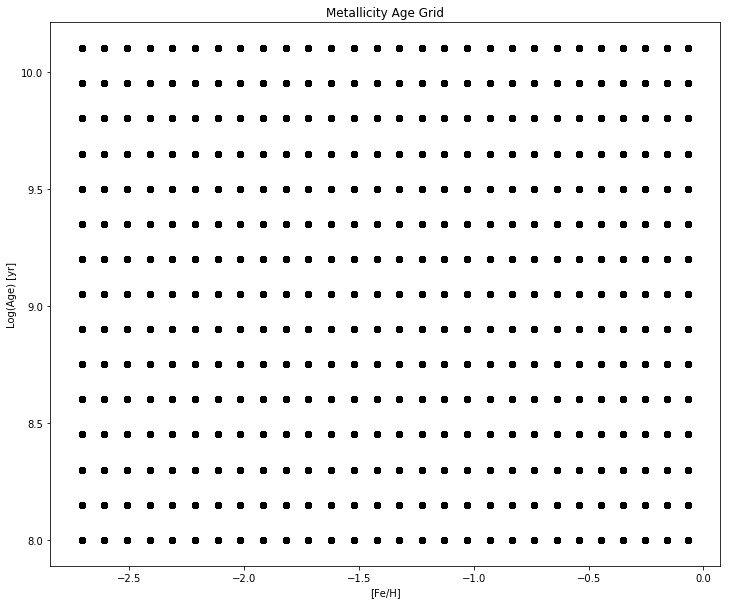

In [4]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(np.log10(parsec['Zini']/0.02),parsec['logAge'],c='k',cmap='jet')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('PARSECgrid.pdf',bbox_inches='tight')
plt.show()

In [7]:
import itertools as it

y1 = parsec['logTe']
y2 = parsec['Ksmag']
y3 = np.log10(parsec['Zini']/0.02)
y4  = parsec['logg']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

In [8]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

0.007780979977408009
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y23', 'y24', 'y34', 'y2sq',
       'y3sq', 'y4sq'], dtype='<U4')]
[array([ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,
       -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,
       -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,
        6.19034227e-01])]


In [9]:
##########################
### Define Model Above ###
##########################

def parfit(x1,x2,x3,x4):
    p = [ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,\
       -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,\
       -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,\
        6.19034227e-01]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
p[7]*np.multiply(x2,x3)+p[8]*np.multiply(x2,x4)+p[9]*np.multiply(x3,x4)+p[10]*(x2**2)+p[11]*(x3**2)+p[12]*(x4**2)

In [74]:
######################
### Calculate Ages ###
######################


CM = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
NM = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
newalpha = np.log10(10**clndr16['ALPHA_M'] + 10**CM ) #+ 10**NM

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],newalpha),clndr16['LOGG'])

In [99]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR): #,nfe,nfeERR
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    #aMnoise = np.random.normal(0, amERR) #[alpha/M]
    #cfenoise = np.random.normal(0, cfeERR) #[C/Fe]
    #nfenoise = np.random.normal(0, nfeERR) #[N/Fe]
    #fehnoise = np.random.normal(0, fehERR) #[Fe/H]
    
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    hxERR = 10**(am)*np.log(10)*amERR
    hyERR = 10**(CM)*np.log(10)*CMERR
    hzERR = 10**(NM)*np.log(10)*NMERR
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    alph = np.log10(10**am+10**cm+10**nm) #+10**nm
    alphERR = np.sqrt((hxERR)**2+(hyERR)**2+(hzERR)**2) #+(hzERR)**2
    
    alphanoise = np.random.normal(0, np.absolute(0.434*(alphERR/alph)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = alph + ((-1)**np.random.randint(2))*alphanoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, aMnew, lggnew

In [100]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    am = clndr16['ALPHA_M'][i]
    amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nam,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR) #,nfe,nfeERR
        ages.append(parfit(nlgT,nks,sal(nmh,nam),nlgg))
    
    devs.append(mad(ages))

In [86]:
# cm = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
# am = clndr16['ALPHA_M']
# amERR = clndr16['ALPHA_M_ERR']
# cfeERR = clndr16['C_FE_ERR']
# fehERR = clndr16['FE_H_ERR']
# mhERR = clndr16['M_H_ERR']
# CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
# test  = 0.434*(np.sqrt((10**(am)*np.log(10)*amERR)**2+(10**(CM)*np.log(10)*CMERR)**2)/np.log10(10**am+10**cm))
# np.where(test<=0)

(array([   3, 1683, 2075]),)

In [94]:
# print(clndr16['C_FE'][3])
# print(clndr16['FE_H'][3])
# print(clndr16['M_H'][3])
# print('[C/M]',clndr16['C_FE'][3]+clndr16['FE_H'][3]-clndr16['M_H'][3])
# print(clndr16['ALPHA_M'][3])
# print(0.434*(np.sqrt((10**(am[3])*np.log(10)*amERR[3])**2+(10**(CM[3])*np.log(10)*CMERR[3])**2)/\
#              np.log10(10**am[3]+10**cm[3])))
# print('denom',np.log10(10**am[3]+10**cm[3]))
# print('numer',np.sqrt((10**(am[3])*np.log(10)*amERR[3])**2+(10**(CM[3])*np.log(10)*CMERR[3])**2))

-0.71739995
-1.1477664
-1.2316663
[C/M] -0.6335
-0.13036701
-1.555441130538944
denom -0.011786608109270113
numer 0.04224279963756357


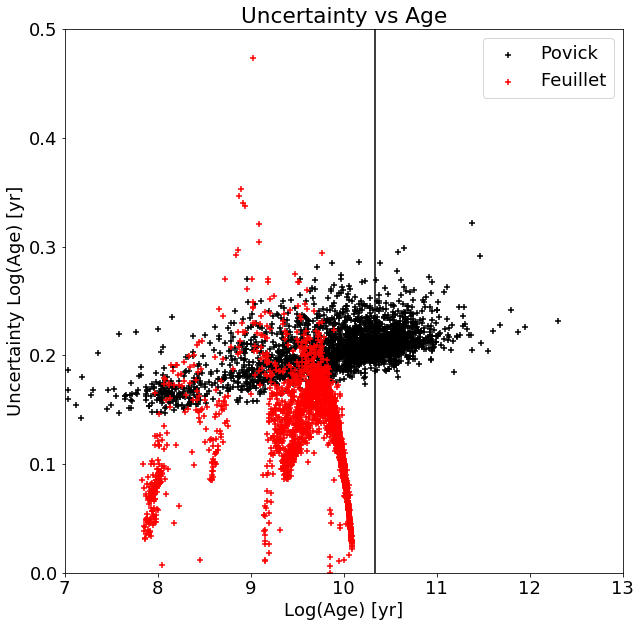

In [101]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(parage,devs,c='k',marker='+',label='Povick')
plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.xlim(7,13)
plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,0.5)
plt.title(r'Uncertainty vs Age')
plt.legend()
#plt.savefig('nograv_uncert_age.pdf',bbox_inches='tight')
plt.show()

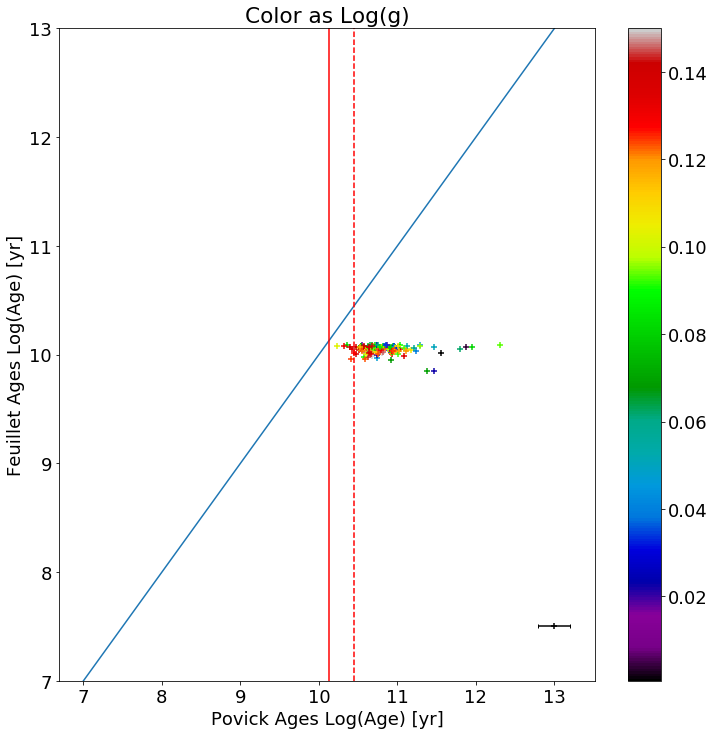

In [102]:
lowgrav = np.where(clndr16['LOGG']<0.15)
plt.figure(figsize=[12,12])
plt.scatter(parage[lowgrav],clnpdfout['P_MEAN'][lowgrav],c=clndr16['LOGG'][lowgrav],marker='+',\
            cmap='nipy_spectral')
# plt.scatter(parage,clnpdfout['P_MEAN'],c=clndr16['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:blue')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+max(devs),c='r',linestyle='--')
plt.xlabel(r'Povick Ages Log(Age) [yr]')
plt.ylabel(r'Feuillet Ages Log(Age) [yr]')
plt.title(r'Color as Log(g)')
#plt.savefig('nograv_age_age.pdf',bbox_inches='tight')
plt.show()

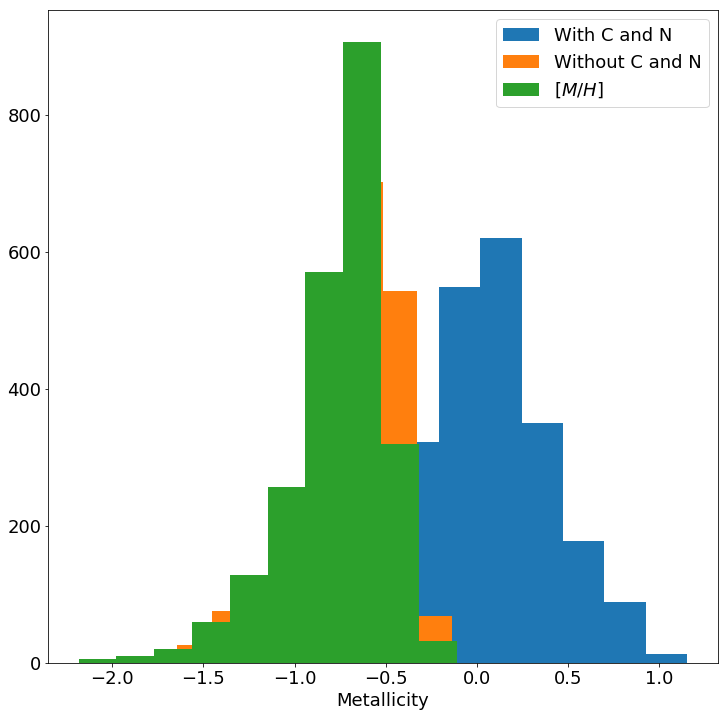

0.8219505

In [119]:
##########################
### Salaris Correction ###
##########################
cm = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
nm = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
newalpha = np.log10(10**clndr16['ALPHA_M']+10**cm+10**nm)

plt.figure(figsize=[12,12])
plt.hist(clndr16['M_H']+np.log(0.638*(10**(newalpha))+0.362),label='With C and N')
plt.hist(clndr16['M_H']+np.log(0.638*(10**(clndr16['ALPHA_M']))+0.362),label='Without C and N')
plt.hist(clndr16['M_H'],label=r'$[M/H]$')
plt.xlabel(r'Metallicity')
plt.legend()
plt.savefig('new_salaris.pdf',bbox_inches='tight')
plt.show()

np.mean(np.log(0.638*(10**(newalpha))+0.362))

$\huge{\textbf{No Gravity below This}}$

In [40]:
no_models = []
no_models_str = []
no_all_var_str = ['y1','y2','y3','y12','y13','y23','y1sq','y2sq','y3sq']
no_all_var = [y1,y2,y3,y12,y13,y23,y1sq,y2sq,y3sq]
for i in range(3, len(all_var)+1):
    for subset in it.combinations(no_all_var,i):
        no_models.append(subset)
    for subset_str in it.combinations(no_all_var_str,i):
        no_models_str.append(np.array(subset_str))
    
no_idx = []
for j in range(len(no_models_str)):
    if no_models_str[j][0]=='y1' and no_models_str[j][1]=='y2' and no_models_str[j][2]=='y3':
        no_idx.append(j)
        
no_models = np.array(no_models)[no_idx]
no_models_str_good = np.array(no_models_str)[no_idx]

In [41]:
######################
### Fit All Models ###
######################

no_model_mads = []
no_model_params = []
no_model_res = []
for i in range(len(no_models)):
    no_pmodl = np.array(no_models[i]).T
    no_pmodl = sm.add_constant(no_pmodl)
    no_model = sm.OLS(parsec['logAge'],no_pmodl).fit()
    no_predictions = no_model.predict(no_pmodl)
    no_residual = no_predictions - parsec['logAge']
    no_model_res.append(max(np.absolute(no_residual)))
    no_model_mads.append(mad(no_residual))
    no_model_params.append(np.asarray(no_model.params))
    
no_best = np.where(no_model_mads == min(no_model_mads))
print(min(no_model_mads))
print(no_models_str_good[no_best])
print(np.asarray(no_model_params)[no_best])

0.05746628233324458
[array(['y1', 'y2', 'y3', 'y12', 'y13', 'y23', 'y1sq', 'y2sq', 'y3sq'],
      dtype='<U4')]
[array([ 1.05592462e+03, -5.37776305e+02,  1.36790634e+01, -2.95641452e+01,
       -3.57645238e+00,  7.54638396e+00, -9.45698641e-02,  6.88765399e+01,
        6.06345313e-03, -3.04370753e-01])]


In [43]:
##################################
### Define No Grav Model Above ###
##################################

def no_parfit(x1,x2,x3):
    p = [ 1.05592462e+03, -5.37776305e+02,  1.36790634e+01, -2.95641452e+01,\
       -3.57645238e+00,  7.54638396e+00, -9.45698641e-02,  6.88765399e+01,\
        6.06345313e-03, -3.04370753e-01]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+\
p[6]*np.multiply(x2,x3)+p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)

In [44]:
##############################
### Calculate No Grav Ages ###
##############################


CM = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
NM = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
newalpha = np.log10(10**clndr16['ALPHA_M'] + 10**CM + 10**NM)

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
no_parage = no_parfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],newalpha))

In [45]:
############################################
### Get No Grav Uncertainties: Add Noise ###
############################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def no_noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR):
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    #aMnoise = np.random.normal(0, amERR) #[alpha/M]
    #cfenoise = np.random.normal(0, cfeERR) #[C/Fe]
    #nfenoise = np.random.normal(0, nfeERR) #[N/Fe]
    #fehnoise = np.random.normal(0, fehERR) #[Fe/H]
    
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    hxERR = 10**(am)*np.log(10)*amERR
    hyERR = 10**(CM)*np.log(10)*CMERR
    hzERR = 10**(NM)*np.log(10)*NMERR
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    alph = np.log10(10**am+10**cm+10**nm)
    alphERR = np.sqrt((hxERR)**2+(hyERR)**2+(hzERR)**2)
    
    alphanoise = np.random.normal(0, 0.434*(alphERR/alph))
    
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = alph + ((-1)**np.random.randint(2))*alphanoise
    return Tnew, Knew, MHnew, aMnew

In [67]:
##############################################
### Get No Grav Uncertainties: Calc Uncert ###
##############################################

no_devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    am = clndr16['ALPHA_M'][i]
    amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    
    no_ages = []
    for j in range(1):
        nlgT,nks,nmh,nam = no_noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR)
        no_ages.append(no_parfit(nlgT,nks,sal(nmh,nam)))
    
    no_devs.append(mad(no_ages))

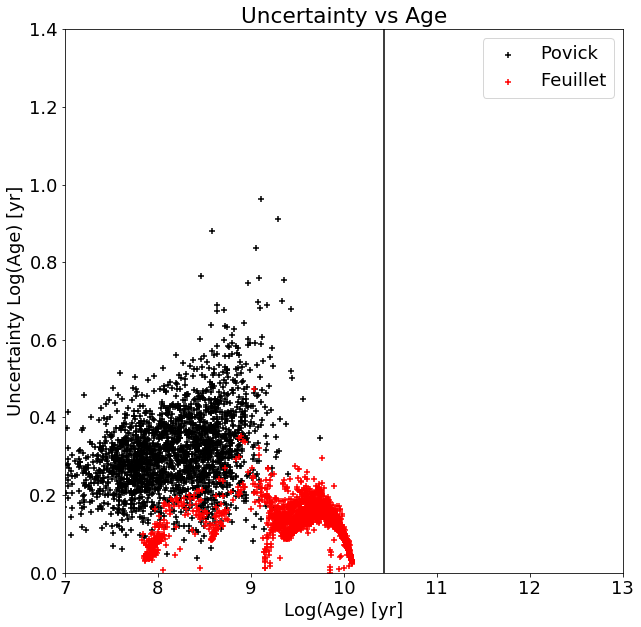

In [70]:
################################
### No Grav Uncertainty Plot ###
################################

plt.figure(figsize=[10,10])
plt.scatter(no_parage,no_devs,c='k',marker='+',label='Povick')
plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.xlim(7,13)
plt.axvline(10.13+np.mean(no_devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,1.4)
plt.title(r'Uncertainty vs Age')
plt.legend()
#plt.savefig('nograv_uncert_age.pdf',bbox_inches='tight')
plt.show()

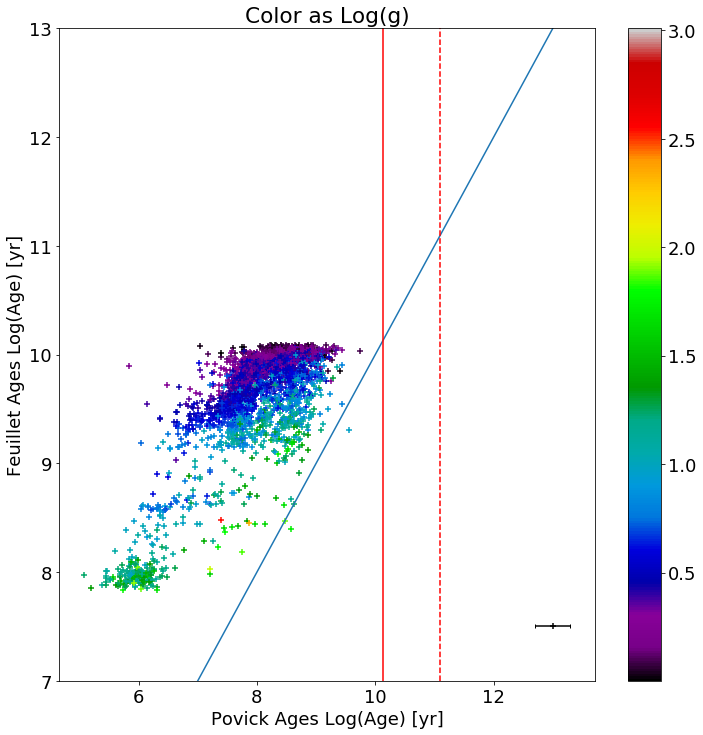

In [71]:
lowgrav = np.where(clndr16['LOGG']<0.15)
plt.figure(figsize=[12,12])
plt.scatter(no_parage,clnpdfout['P_MEAN'],c=clndr16['LOGG'],marker='+',\
            cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:blue')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(no_devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+max(no_devs),c='r',linestyle='--')
plt.xlabel(r'Povick Ages Log(Age) [yr]')
plt.ylabel(r'Feuillet Ages Log(Age) [yr]')
plt.title(r'Color as Log(g)')
#plt.savefig('nograv_age_age.pdf',bbox_inches='tight')
plt.show()

(array([ 39., 834., 968., 306., 126.,  26.,   5.,   1.,   0.,   2.]),
 array([0.28233242, 0.36251217, 0.44269192, 0.5228717 , 0.6030514 ,
        0.6832312 , 0.7634109 , 0.8435907 , 0.9237704 , 1.0039501 ,
        1.0841299 ], dtype=float32),
 <a list of 10 Patch objects>)

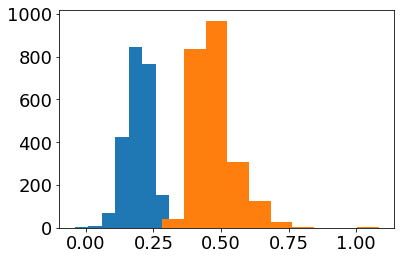

In [73]:
test = np.log10(10**clndr16['ALPHA_M'] + 10**CM)
test2 = np.log10(10**clndr16['ALPHA_M'] + 10**CM + 10**NM)
plt.hist(test)
plt.hist(test2)
